# Object Detection using Tensorflow Object Detection API

In this lab exercise, we will use our trained custom object detection model to detect balloons in both images and videos. 


## Imports and Setup

Let's start with the base imports.

In [1]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from six import BytesIO
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import cv2

## Utilities

Run the following cell to create some utils that will be needed later:

- Helper method to load an image


In [2]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: the file path to the image

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    image = None
    if(path.startswith('http')):
        response = urlopen(path)
        image_data = response.read()
        image_data = BytesIO(image_data)
        image = Image.open(image_data)
    else:
        image_data = tf.io.gfile.GFile(path, 'rb').read()
        image = Image.open(BytesIO(image_data))

        (im_width, im_height) = image.size
        
    return np.array(image.getdata())[:,:3].reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)



## Visualization tools

To visualize the images with the proper detected boxes, we will use the TensorFlow Object Detection API. 

In [3]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

### Load label map data (for plotting).

Label maps correspond index numbers to category name. For example, if our COCO-trained model predicts `5`, we know that this corresponds to `airplane`. Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine.

We will load the label_map we created for our balloon detector, which only contains one class.

In [4]:
PATH_TO_LABELS = 'data/label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [5]:
category_index

{1: {'id': 1, 'name': 'boar'}, 2: {'id': 2, 'name': 'otter'}}

## Loading our saved custom model

Here we will load our trained balloon detection model and use it later to detect our picture and videos.

In [6]:
## Uncomment the following if you want to use a pretrained balloon detection model

# !wget https://nyp-aicourse.s3-ap-southeast-1.amazonaws.com/pretrained-models/balloon_model.tar.gz
# !mkdir mymodel
# !tar xzvf balloon_model.tar.gz -C mymodel

In [7]:
model = 'ssd_mobilenet_v2_320x320_coco17_tpu-8'
experiment='run1'
export_root_dir = '/Users/s1756519b/as1/exported_models'

# Uncomment the following if you want to use a pretrained balloon detection model
# model_dir = 'mymodel/saved_model'
model_dir = os.path.join(export_root_dir, f'{model}/{experiment}/saved_model')

# load the model
detection_model = tf.saved_model.load(str(model_dir))

2021-12-14 10:30:03.920503: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading an image

Let's try the model on your own image. You can upload your image using the code below. The code below uses ipywidgets [FileUpload](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html) widget to upload file


In [8]:
import ipywidgets as widgets

uploader = widgets.FileUpload(
    accept='image/*',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
)

display(uploader)


FileUpload(value={}, accept='image/*', description='Upload')

After upload, we need to write the upload data to a file. The content of the upload data can be found in ``uploader.data[0]``.

In [10]:
key = next(iter(uploader.value))

samples_folder = 'test_samples'

if not os.path.exists(samples_folder):
    os.mkdir(samples_folder)

image_path = os.path.join(samples_folder, key)

with open(image_path, "w+b") as file:
    file.write(uploader.data[0])



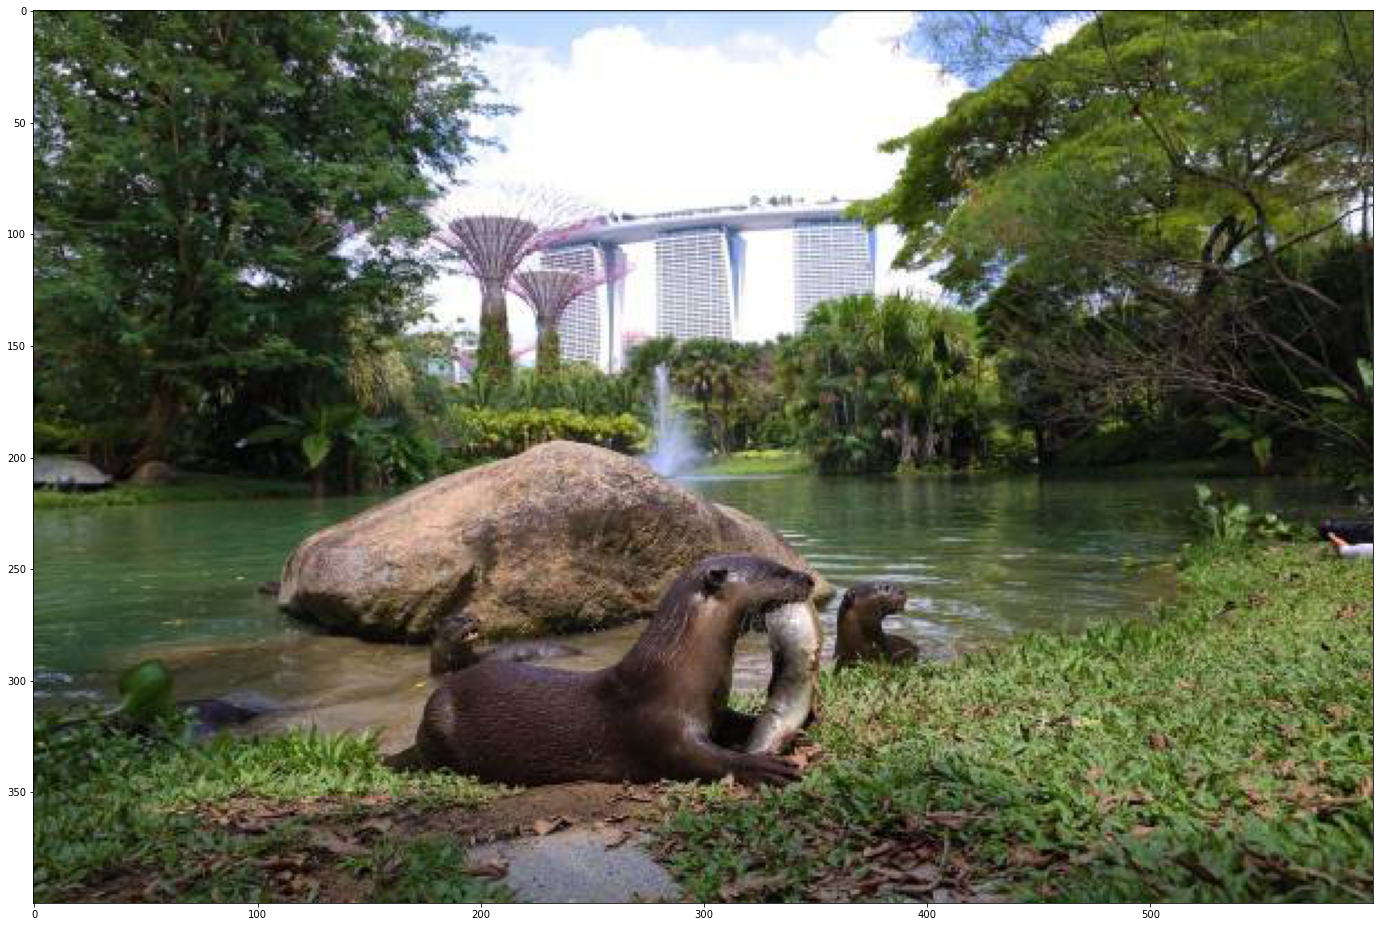

In [11]:
image_np = load_image_into_numpy_array(image_path)
plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()

## Doing the inference

To do the inference we just need to call our detection model. The detection model expect the following input and output a dictionary of items described below:

*Inputs*:

A three-channel image of variable size - the model does NOT support batching. The input tensor is a tf.uint8 tensor with shape [1, height, width, 3] with values in [0, 255].

*Outputs*:

The output dictionary contains:

- num_detections: a tf.int tensor with only one value, the number of detections [N].

- detection_boxes: a tf.float32 tensor of shape [N, 4] containing bounding box coordinates in the following order: [ymin, xmin, ymax, xmax].
- detection_classes: a tf.int tensor of shape [N] containing detection class index from the label file.
- detection_scores: a tf.float32 tensor of shape [N] containing detection scores.
- raw_detection_boxes: a tf.float32 tensor of shape [1, M, 4] containing decoded detection boxes without Non-Max suppression. M is the number of raw detections.
- raw_detection_scores: a tf.float32 tensor of shape [1, M, 90] and contains class score logits for raw detection boxes. M is the number of raw detections.
- detection_anchor_indices: a tf.float32 tensor of shape [N] and contains the anchor indices of the detections after NMS.
- detection_multiclass_scores: a tf.float32 tensor of shape [1, N, 90] and contains class score distribution (including background) for detection boxes in the image including background class.


In [12]:
# running inference
results = detection_model(image_np)

# different object detection models have additional results
result = {key:value.numpy() for key,value in results.items()}
print(result.keys())

dict_keys(['num_detections', 'raw_detection_boxes', 'detection_multiclass_scores', 'detection_classes', 'raw_detection_scores', 'detection_scores', 'detection_anchor_indices', 'detection_boxes'])


## Visualizing the results

Here is where we will need the TensorFlow Object Detection API to show the squares from the inference step (and the keypoints when available). The full documentation of this method can be seen [here](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py)

Here you can, for example, set `min_score_thresh` to other values (between 0 and 1) to allow more detections in or to filter out more detections.

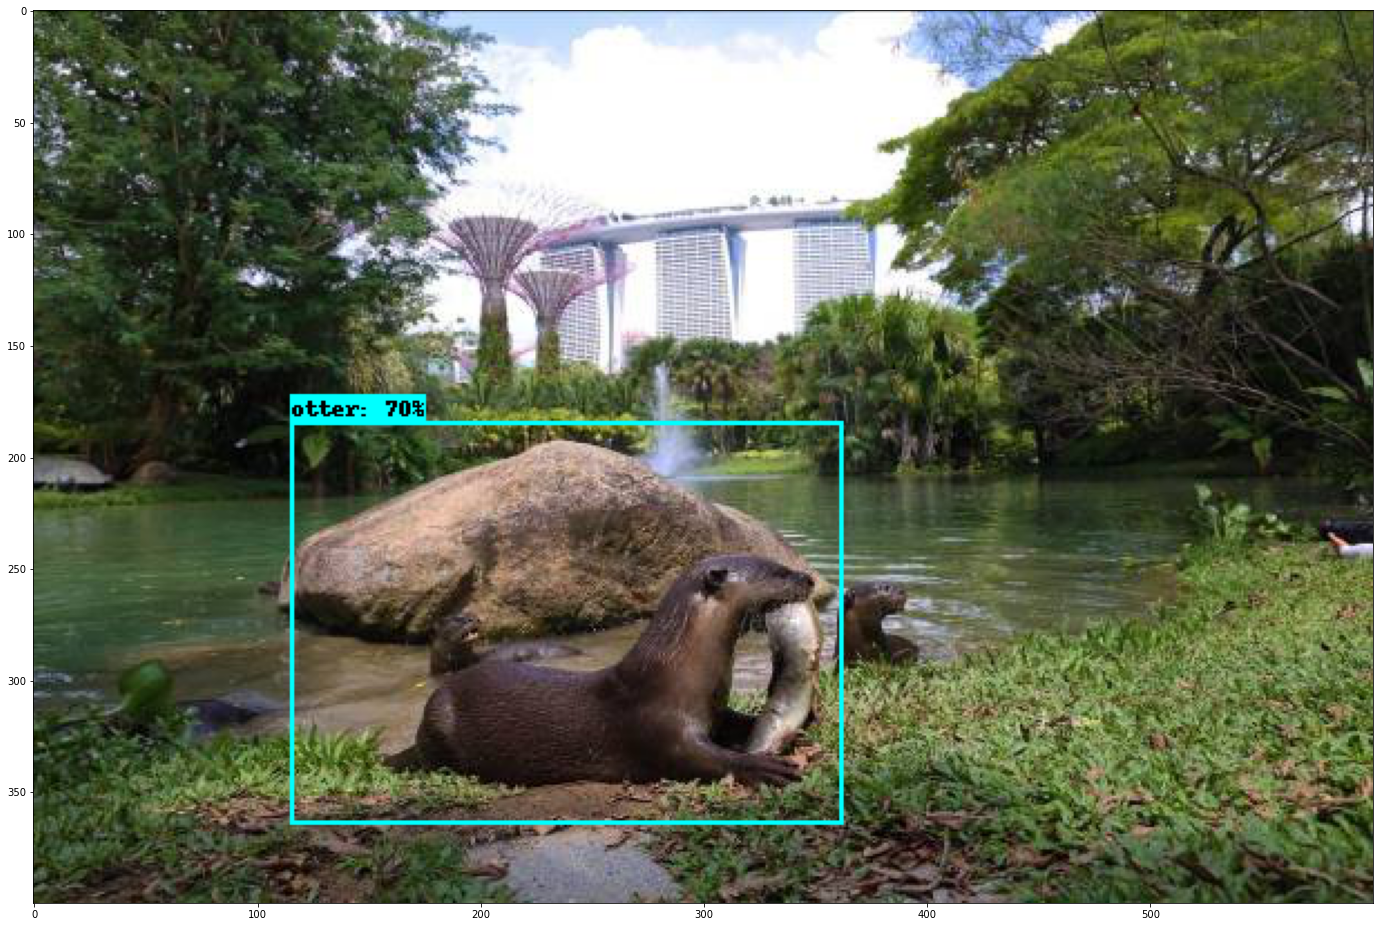

In [13]:
label_id_offset = 0
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.60,
      agnostic_mode=False,
      line_thickness=2)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.show()

## Object Detection on Video

We can also do object detection on a video file. We just treat our video file as a sequence of frames (images) and we run the detector on each frame. After we draw the bounding boxes on the frame (image), we then write the new image (with bounding boxes) to a video file, frame by frame. 


In [83]:
def write_video(video_in_filepath, video_out_filepath, detection_model):
    if not os.path.exists(video_in_filepath):
        print('video filepath not valid')
    
    video_reader = cv2.VideoCapture(video_in_filepath)
    
    nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    fps = video_reader.get(cv2.CAP_PROP_FPS)
    
    video_writer = cv2.VideoWriter(video_out_filepath,
                               cv2.VideoWriter_fourcc(*'mp4v'), 
                               fps, 
                               (frame_w, frame_h))

    for i in tqdm(range(nb_frames)):
        ret, image_np = video_reader.read()
        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.uint8)
        results = detection_model(input_tensor)
        viz_utils.visualize_boxes_and_labels_on_image_array(
                  image_np,
                  results['detection_boxes'][0].numpy(),
                  (results['detection_classes'][0].numpy()+1).astype(int),
                  results['detection_scores'][0].numpy(),
                  category_index,
                  use_normalized_coordinates=True,
                  max_boxes_to_draw=200,
                  min_score_thresh=.50,
                  agnostic_mode=False,
                  line_thickness=2)

        video_writer.write(np.uint8(image_np))
                
    # Release camera and close windows
    video_reader.release()
    video_writer.release() 
    cv2.destroyAllWindows() 
    cv2.waitKey(1)

In [84]:
uploader = widgets.FileUpload(
    accept='.mp4',  # Accepted file extension only '.mp4'
    multiple=False  # True to accept multiple files upload else False
)

display(uploader)

FileUpload(value={}, accept='.mp4', description='Upload')

In [85]:
key = next(iter(uploader.value))

samples_folder = 'test_samples'

if not os.path.exists(samples_folder):
    os.mkdir(samples_folder)
video_in_file = os.path.join(samples_folder, key)
with open(video_in_file, "w+b") as file:
    file.write(uploader.data[0])

In [86]:
from pathlib import Path

basename = Path(video_in_file).stem
video_out_file = os.path.join(samples_folder, basename + '_detected' + '.mp4')

write_video(video_in_file, video_out_file, detection_model)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 358/358 [00:34<00:00, 10.35it/s]
